In [1]:
%run "01_Fuentes.ipynb"
print('[encadenado] 02 ha ejecutado 01 y ya tiene `lap` y variables base.')


[encadenado] 02 ha ejecutado 01 y ya tiene `lap` y variables base.


# 02 · Limpieza, EDA y Feature Engineering 


In [2]:
lap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2843 entries, 0 to 2842
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2843 non-null   object 
 1   Brand             2810 non-null   object 
 2   Screen_Size       2756 non-null   object 
 3   CPU_Model         2628 non-null   object 
 4   Ram               2711 non-null   object 
 5   Operating_System  2723 non-null   object 
 6   Rating            2283 non-null   float64
 7   Series            2501 non-null   object 
 8   Color             2109 non-null   object 
 9   Resolution        182 non-null    object 
 10  Weight            66 non-null     object 
 11  USB               35 non-null     float64
 12  Battery           7 non-null      object 
 13  Graphics          2063 non-null   object 
 14  Disk_size         2248 non-null   object 
 15  Card_desc         2635 non-null   object 
 16  Price             1863 non-null   object 


In [3]:
total = len(lap)
nulos = lap.isna().sum()
porcentaje_nulos = (nulos/total)*100

In [4]:
porcentaje_nulos.sort_values()

Title                0.000000
Brand                1.160746
Screen_Size          3.060148
Operating_System     4.220893
Ram                  4.642983
Card_desc            7.316215
CPU_Model            7.562434
Series              12.029546
Rating              19.697503
Disk_size           20.928597
Color               25.817798
Graphics            27.435807
Price               34.470630
Resolution          93.598312
Weight              97.678509
USB                 98.768906
Battery             99.753781
dtype: float64

In [5]:
## eliminamos las que tienen demasiados Nan (y que además no son súper importantes)

lap = lap.drop(['Battery','USB','Weight'],axis=1)

In [6]:
# usaremos esto en adelante 
total = len(lap)
nulos = lap.isna().sum()
porcentaje_nulos = (nulos/total)*100


In [7]:
## Tenemos en 'Title' la info que podemos meter en otras columnas (y no hay nulos)

# la primera palabra es la marca

lap['Title']

0       Microsoft Surface Laptop Intel Core i5 7th Gen...
1       Microsoft Surface Laptop 3 13.5" Touch-Screen ...
2       Microsoft Surface Laptop (Intel Core i7, 16GB ...
3       Microsoft Surface Laptop 3, 10th Gen Intel Cor...
4       2022 Microsoft Surface Laptop Go 12.4" Touchsc...
                              ...                        
2838    Microsoft Surface Laptop Go 12.4" Touchscreen ...
2839    Microsoft Surface Laptop Go 12.4" Touchscreen ...
2840    Microsoft Surface Laptop Go 12.4in Touchscreen...
2841    Microsoft Surface Laptop Go 12.4" Touchscreen ...
2842    Microsoft Surface Laptop Go 12.4" Touchscreen ...
Name: Title, Length: 2843, dtype: object

In [8]:
sin_marca = lap[lap['Brand'].isna()].copy()
sin_marca['Brand'] = sin_marca['Title'].str.split(' ').str.get(0)

In [9]:
lap.loc[sin_marca.index, 'Brand'] = sin_marca['Brand']
#tenemos Brand limpio y sin nulos

In [10]:
porcentaje_nulos.sort_values()

Title                0.000000
Brand                1.160746
Screen_Size          3.060148
Operating_System     4.220893
Ram                  4.642983
Card_desc            7.316215
CPU_Model            7.562434
Series              12.029546
Rating              19.697503
Disk_size           20.928597
Color               25.817798
Graphics            27.435807
Price               34.470630
Resolution          93.598312
dtype: float64

In [11]:
## por orden. Vamos con screen size.
# vemos en Title, que las pulgadas son siempre:
# o uno u dos numeros, punto, otro num y "" 
# o un digito solo y ""
# o también con inches 
lap['Screen_Size'] = (
    lap['Screen_Size'].astype(str)
    .str.replace('Inches','', case=False)
    .str.replace('"','', regex=False)
    .str.strip()                               # <-- con paréntesis
    .str.replace(',', '.', regex=False)
)
lap['Screen_Size'] = pd.to_numeric(lap['Screen_Size'], errors='coerce')

In [12]:
# usamos regex
# queremos los casos como escriben las pulgadas en Title
# creamos máscara para aplicar el regex solamente a los nulos


numeritos = r'(\d{2}(?:\.\d)?)\"'
mask = lap['Screen_Size'].isna()

lap.loc[mask, 'Screen_Size'] = pd.to_numeric(
    lap.loc[mask, 'Title'].str.extract(numeritos, expand=False),
    errors='coerce'
)

print(lap['Screen_Size'].dtype)       
print('NaN en Screen_Size:', lap['Screen_Size'].isna().sum())

float64
NaN en Screen_Size: 51


In [13]:
lap['Screen_Size'].isna().sum()

np.int64(51)

In [14]:
# Limpio lo que ya tenga en Screen_Size 
lap['Screen_Size'] = (
    lap['Screen_Size'].astype(str)
    .str.replace('Inches','', case=False)
    .str.replace('"','', regex=False)
    .str.replace(',', '.', regex=False)
    .str.strip()
)
lap['Screen_Size'] = pd.to_numeric(lap['Screen_Size'], errors='coerce')

# Normaliza comillas/guiones en Title
lap['Title_norm'] = (
    lap['Title'].astype(str)
    .str.replace('”','"', regex=False)
    .str.replace('“','"', regex=False)
    .str.replace('″','"', regex=False)
    .str.replace('-','-', regex=False)  # non-breaking hyphen
    .str.replace('–','-', regex=False)
    .str.replace('—','-', regex=False)
)

# Extrae SOLO donde falte, admitiendo " / inch / inches / in y decimales , o .
mask = lap['Screen_Size'].isna()
pat = r'(?i)\b(\d{1,2}(?:[.,]\d{1,2})?)\s*(?:["]|-?\s*inch(?:es)?\b|in\b)'

ext = (lap.loc[mask, 'Title_norm']
         .str.extract(pat, expand=False)
         .str.replace(',', '.', regex=False))

lap.loc[mask, 'Screen_Size'] = pd.to_numeric(ext, errors='coerce')

# Diagnóstico 
print('NaN restantes:', lap['Screen_Size'].isna().sum())
print(lap.loc[lap['Screen_Size'].isna(), 'Title'].head(10).to_list())

NaN restantes: 27
['Refurbished Panasonic Toughbook CF-33, Intel Core i5-6300U @2.4GHz, Ram 8GB, 256GB SSD,4G Lte,No Key', '2nd USB/CF-20/8GB/256GB SSD/Windows 10/WIFI/4G LTE/Multi Carrier/Webcam/Emissive Backlit Keyboard/', 'Toughbook U1 Ultra Mobile PC', 'PANASONIC FZ-VZSU88U', 'Acer Predator Triton 500 SE Gaming/Creator Laptop | 12th Gen Intel i9-12900H & Nitro 5 AN515-57-79TD Gaming Laptop | Intel Core i7-11800H | NVIDIA GeForce RTX 3050 Ti Laptop GPU', 'MK8/CF-19/16GB RAM/ 4G LTE/ 500GB SSD/ WINDOWS 10 PRO 64 BIT/2.7 GHZ/TOUCH SCREEN/', 'CF30 C2D/1.6 13.3TCH 2GB-160GB WLS EBK GOBI WXP-WV', 'Panasonic CF-52VAABY1M-RW Win7 Intel Core I5-3360m 2.80ghz 15.4', 'Panasonic Toughbook CF-53JJCZY1M 14 LED Notebook Intel Core i5-3320M 2.60 GHz', 'GIGABYTE Ultra Compact Mini PC/Intel UHD Graphics 600/ M.2 SSD/HDMI (2.0A)/ DP1.2A Component- GB-BLCE-4105']


In [15]:
moda_size = lap['Screen_Size'].mode().iloc[0]

lap['Screen_Size'] = lap['Screen_Size'].fillna(moda_size)



In [16]:
#### podemos usar también regex para RAM y CPU 

# la RAM va en el formato 16GB RAM o bien 8GB Memory. Hacemos el regex 

mascara2 = lap['Ram'].isna()

patronRAM = r'(?i)\b(\d{1,3})\s*GB\s*(?:RAM|Memory)\b'


lap.loc[mascara2,'Ram'] = (lap.loc[mascara2,'Title'].str.extract(patronRAM)[0])

In [17]:
lap['Ram'].isna().sum()
# como se puede apreciar, sigue habiendo nulos. 
# por lo que veo en el csv, hay casos en los que no se especifica la RAM. Tendremos que eliminar estas filas

np.int64(91)

In [18]:
# pasamos a numeros enteros 

lap['Ram'] = lap['Ram'].astype(str).str.replace(r'[^0-9]', '', regex=True)
lap['Ram'] = pd.to_numeric(lap['Ram'], errors='coerce')
lap = lap.dropna(subset=['Ram']).copy()
lap['Ram'] = lap['Ram'].astype(int)

In [19]:
## ahora nos toca ir a por la columna CPU (tenemos un 7% de nulos)

# la CPU está en Title también
# el formato es la CPU entera. 
# buscaremos en Title los 5 CPUs más repetidos en la columna CPU.


In [20]:
lap['CPU_Model'].str.strip().value_counts(dropna=False).head(20)

# tenemos una columna de CPU con muuuuchos tipos diferentes de strings.
# Luego vemos qué hacer con toda esta info

CPU_Model
Core i7                 404
Core i5                 294
Core i7 Family          163
NaN                     146
Intel Core i5           114
Celeron                 111
Intel Core i7           104
Celeron N4020           101
Core i5 Family           68
Unknown                  68
Core i3                  62
Core i9                  61
Celeron N                47
Ryzen 5                  44
Intel Core i9            39
Ryzen 7                  36
Core i5-1035G1           35
Celeron N4000            34
AMD Ryzen 7              33
Intel Core i5-1135G7     33
Name: count, dtype: int64

In [21]:
# por ahora, vamos a rellenar los nulos con la info que 
# podamos encontrar en Title

mascara3 = lap['CPU_Model'].isna()

cpu_pattern = r'(?i)\b(' \
              r'Intel\s*Core\s*i[3-9]|' \
              r'Intel\s*i[3-9]|' \
              r'i[3-9]-\d{4,5}[A-Z]?|' \
              r'Ryzen\s*[3579](?:\s*\d{4}[A-Z]?)?|' \
              r'Ryzen\s*[3579]|' \
              r'Apple\s*M\d|' \
              r'Exynos\s*\d+|' \
              r'Celeron|Pentium|Athlon|Snapdragon\s*\d+' \
              r')\b'

extracted = lap.loc[mascara3, 'Title'].str.extract(cpu_pattern, expand=False)
lap.loc[mascara3, 'CPU_Model'] = (
    extracted
      .str.replace(r'\s+', ' ', regex=True)  
      .str.strip()
)

In [22]:
lap['CPU_Model'].nunique()

193

In [23]:
pd.reset_option('display.max_rows') 

lap['CPU_Model']

0       1.2GHz Cortex A8 Processor
1                          Core i5
2                          Core i7
3                   Core i5-1035G7
4                          Core i5
                   ...            
2838                Core i5-1035G1
2839                Core i5-1035G1
2840                Core i5-1035G1
2841                Core i5-1035G1
2842                Core i5-1035G1
Name: CPU_Model, Length: 2752, dtype: object

In [24]:
# ok. tenemos 193 CPUs distintas. Buscando las especificaciones,
# vamos a crear nuevos grupos 

In [25]:
import numpy as np, re
import pandas as pd

# Texto normalizado
cpu = (lap['CPU_Model'].fillna('')
       .astype(str).str.lower().str.replace(r'\s+', ' ', regex=True).str.strip())

# 1) Vendor
lap['CPU_Vendor'] = np.select(
    [
        cpu.str.contains(r'\bintel\b|core i|celeron|pentium|xeon|atom', na=False),
        cpu.str.contains(r'\bamd\b|ryzen|athlon|a series|a[46]\b|r series', na=False),
        cpu.str.contains(r'\bapple\b|^m\d\b|\bm1\b|\bm2\b|\bm3\b', na=False),
        cpu.str.contains(r'snapdragon|qualcomm|exynos|mediatek|kompanio|cortex|arm\b', na=False),
    ],
    ['Intel','AMD','Apple','ARM'],
    default='Unknown'
)

# 2) Family (compacta)
def cpu_family(s: str) -> str:
    s = str(s)
    if re.search(r'\b(i3)\b', s):  return 'i3'
    if re.search(r'\b(i5)\b', s):  return 'i5'
    if re.search(r'\b(i7)\b', s):  return 'i7'
    if re.search(r'\b(i9)\b', s):  return 'i9'
    if re.search(r'ryzen\s*9', s):  return 'Ryzen9'
    if re.search(r'ryzen\s*7', s):  return 'Ryzen7'
    if re.search(r'ryzen\s*5', s):  return 'Ryzen5'
    if re.search(r'ryzen\s*3', s):  return 'Ryzen3'
    if re.search(r'\bceleron\b', s): return 'Celeron'
    if re.search(r'\bpentium\b', s): return 'Pentium'
    if re.search(r'\bathlon\b', s):  return 'Athlon'
    if re.search(r'\bxeon\b', s):    return 'Xeon'
    if re.search(r'\batom\b', s):    return 'Atom'
    if re.search(r'\bcore 2 duo\b', s): return 'Core2'
    if re.search(r'\bcore m\b|\bm-\d', s): return 'CoreM'
    if re.search(r'\bapple\b|\bm[123]\b', s): return 'AppleM'
    if re.search(r'snapdragon', s):  return 'Snapdragon'
    if re.search(r'exynos', s):      return 'Exynos'
    if re.search(r'mediatek|kompanio', s): return 'MediaTek'
    if re.search(r'\ba series\b|\ba[46]\b|amd a ', s): return 'A-series'
    return 'Other'

lap['CPU_Family'] = cpu.apply(cpu_family)

# 3) Generación / serie aproximada
def intel_gen(s: str):
    m = re.search(r'i[3579][ -]?(\d{4,5})', s)
    if not m: return np.nan
    num = m.group(1)
    return int(num[:1]) if len(num)==4 else int(num[:2])  # 8750->8, 11800->11

def ryzen_gen(s: str):
    m = re.search(r'ryzen\s*[3579]\s*(\d{4})', s)
    if not m: return np.nan
    return int(m.group(1)[0])  # 5800 -> 5

def apple_m_gen(s: str):
    m = re.search(r'\bm(\d)\b', s)
    return int(m.group(1)) if m else np.nan

lap['CPU_Gen'] = pd.Series(np.nan, index=lap.index, dtype='float')
lap.loc[lap['CPU_Vendor'].eq('Intel'), 'CPU_Gen'] = cpu[lap['CPU_Vendor'].eq('Intel')].apply(intel_gen)
lap.loc[lap['CPU_Vendor'].eq('AMD'),   'CPU_Gen'] = cpu[lap['CPU_Vendor'].eq('AMD')].apply(ryzen_gen)
lap.loc[lap['CPU_Vendor'].eq('Apple'), 'CPU_Gen'] = cpu[lap['CPU_Vendor'].eq('Apple')].apply(apple_m_gen)
lap['CPU_Gen'] = lap['CPU_Gen'].astype('Int64')

# 4) Clase móvil/desktop por sufijo
def intel_class(s: str):
    if re.search(r'\b(hx|hk|hq|h)\b', s): return 'Mobile-H'
    if re.search(r'\b(u|y)\b', s) or re.search(r'g\d', s): return 'Mobile-U/G'
    return 'Desktop/Unknown'

lap['CPU_Class'] = 'Other'
mask_i = lap['CPU_Vendor'].eq('Intel')
lap.loc[mask_i, 'CPU_Class'] = cpu[mask_i].apply(intel_class)
# AMD móvil con H/U
mask_a = lap['CPU_Vendor'].eq('AMD')
lap.loc[mask_a & cpu.str.contains(r'\bh\b'), 'CPU_Class'] = 'Mobile-H'
lap.loc[mask_a & cpu.str.contains(r'\bu\b'), 'CPU_Class'] = 'Mobile-U/G'

# 5) Arquitectura
lap['CPU_Arch'] = np.where(lap['CPU_Vendor'].isin(['Apple','ARM']), 'ARM', 'x86')

# Rellenar Family desde Title si quedó 'Other' o NaN
mask_fill = lap['CPU_Family'].eq('Other') | lap['CPU_Family'].isna()
t = (lap.loc[mask_fill, 'Title'].fillna('').astype(str)
        .str.lower().str.replace(r'\s+', ' ', regex=True))
lap.loc[mask_fill & t.str.contains(r'\bi3\b'), 'CPU_Family'] = 'i3'
lap.loc[mask_fill & t.str.contains(r'\bi5\b'), 'CPU_Family'] = 'i5'
lap.loc[mask_fill & t.str.contains(r'\bi7\b'), 'CPU_Family'] = 'i7'
lap.loc[mask_fill & t.str.contains(r'\bi9\b'), 'CPU_Family'] = 'i9'
lap.loc[mask_fill & t.str.contains(r'ryzen\s*9'), 'CPU_Family'] = 'Ryzen9'
lap.loc[mask_fill & t.str.contains(r'ryzen\s*7'), 'CPU_Family'] = 'Ryzen7'
lap.loc[mask_fill & t.str.contains(r'ryzen\s*5'), 'CPU_Family'] = 'Ryzen5'
lap.loc[mask_fill & t.str.contains(r'ryzen\s*3'), 'CPU_Family'] = 'Ryzen3'
lap['CPU_Family'] = lap['CPU_Family'].fillna('Other')


In [26]:
lap.head(3
         )

,Title,Brand,Screen_Size,CPU_Model,Ram,Operating_System,Rating,Series,Color,Resolution,Graphics,Disk_size,Card_desc,Price,Title_norm,CPU_Vendor,CPU_Family,CPU_Gen,CPU_Class,CPU_Arch
0,Microsoft Surface Laptop Intel Core i5 7th Gen...,Microsoft,13.5,1.2GHz Cortex A8 Processor,8,Windows 10,4.4,Intel,Platinum,NaN,Intel HD Graphics 620,256 GB,Integrated,NaN,Microsoft Surface Laptop Intel Core i5 7th Gen...,ARM,i5,<NA>,Other,ARM
1,"Microsoft Surface Laptop 3 13.5"" Touch-Screen ...",Microsoft,13.5,Core i5,8,Windows 10,4.4,Microsoft Surface,Matte Black,NaN,NaN,NaN,NaN,NaN,"Microsoft Surface Laptop 3 13.5"" Touch-Screen ...",Intel,i5,<NA>,Desktop/Unknown,x86
2,"Microsoft Surface Laptop (Intel Core i7, 16GB ...",Microsoft,13.5,Core i7,16,Windows 10 S,3.9,Surface Laptop,Platinum,NaN,Intel Iris Plus Graphics 640,512 GB,Integrated,NaN,"Microsoft Surface Laptop (Intel Core i7, 16GB ...",Intel,i7,<NA>,Desktop/Unknown,x86


In [27]:
cols = ['CPU_Vendor','CPU_Family','CPU_Gen','CPU_Class','CPU_Arch']

n_total = len(lap)
n_nulls = lap[cols].isna().sum()
pct_nulls = (lap[cols].isna().mean() * 100).round(2)

resumen_na = (
    pd.DataFrame({'n_nulls': n_nulls, 'pct_nulls': pct_nulls})
      .sort_values('n_nulls', ascending=False)
)

print(f'Filas totales: {n_total}')
print(resumen_na)


Filas totales: 2752
            n_nulls  pct_nulls
CPU_Gen        2325      84.48
CPU_Vendor        0       0.00
CPU_Family        0       0.00
CPU_Class         0       0.00
CPU_Arch          0       0.00


In [28]:
# Perfecto. solo hay nulos en CPU_Gen, asíque la eliminamos 

lap = lap.drop(['CPU_Gen'],axis=1)

In [29]:
# y eliminamos CPU MOdel porque ya hemos aprovechado su info

lap = lap.drop(['CPU_Model'],axis=1)

In [30]:
col_eliminar = ['Card_desc', 'Resolution','Title_norm','Series']
lap = lap.drop(columns=col_eliminar)

In [31]:
lap['Price'] = (
    lap['Price'].astype(str)
                 .str.replace(r'[$,]', '', regex=True)
                 .astype(float)
)

In [32]:
lap.dtypes

Title                object
Brand                object
Screen_Size         float64
Ram                   int64
Operating_System     object
Rating              float64
Color                object
Graphics             object
Disk_size            object
Price               float64
CPU_Vendor           object
CPU_Family           object
CPU_Class            object
CPU_Arch             object
dtype: object

In [33]:
# seguimos orden. vamos a por Operating System 

lap['Operating_System']

0            Windows 10
1            Windows 10
2          Windows 10 S
3       Windows 10 Home
4        Windows 11 Pro
             ...       
2838     Windows 10 Pro
2839     Windows 10 Pro
2840         Windows 10
2841     Windows 10 Pro
2842    Windows 10 Home
Name: Operating_System, Length: 2752, dtype: object

In [34]:
#veamos si el sistema operativo es muy representativo para el precio. 

def os_family(s: str) -> str:
    s = str(s).lower()
    if 'windows 11' in s: return 'Windows 11'
    if 'windows 10' in s: return 'Windows 10'
    if 'mac' in s or 'macos' in s or 'os x' in s: return 'macOS'
    if 'chrome' in s: return 'ChromeOS'
    if 'linux' in s or 'ubuntu' in s: return 'Linux'
    return 'Other'

lap['OS_Family'] = lap['Operating_System'].apply(os_family)

osfam_stats = (
    lap.dropna(subset=['OS_Family','Price'])
       .groupby('OS_Family')['Price']
       .agg(count='size', mean='mean', median='median', std='std')
       .sort_values('mean', ascending=False)
)
print(osfam_stats)

            count         mean    median          std
OS_Family                                            
macOS           5  2054.302000  1847.990   679.629234
Other          85  1430.295765   979.990  1035.891565
Windows 10    683  1146.293031   800.230  1027.083155
Windows 11    853  1102.571395   799.000   858.784249
ChromeOS      176   224.882159   179.475   170.484823


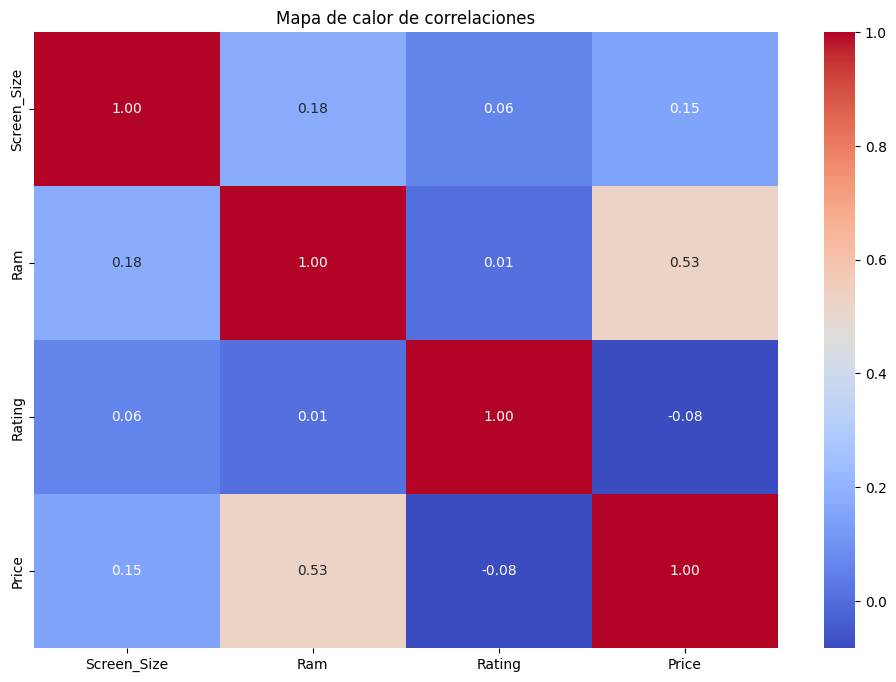

In [35]:
# mapa de calor. Se aprecia una gran relación de RAM con precio/ las familias de sistemas operativos 

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
corr = lap.corr(numeric_only=True)  # numeric_only=True evita problemas con columnas no numéricas
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones")
plt.show()


In [36]:
def os_family(s: str) -> str:
    s = str(s).lower()
    if 'chrome' in s: return 'ChromeOS'
    if 'windows' in s: return 'Windows'
    if 'mac' in s or 'macos' in s or 'os x' in s: return 'macOS'
    return 'Other'

lap['OS_Family'] = lap['Operating_System'].apply(os_family)
# luego ohe en el pipeline; si no, one-hot rápido:
lap = pd.get_dummies(lap, columns=['OS_Family'], drop_first=True)
# y nos la quitamos de encima
lap = lap.drop(columns=['Operating_System'])


In [37]:
 #vemos que la columna COLOR está contaminada con RAM y demás. eliminamos

lap=lap.drop(['Color'],axis=1)

In [38]:
# graphics es una lista con muchísimos tipos. Además, no puedo separar por marca, porque serían demasiadas. 

lap = lap.drop(['Graphics'], axis=1)

In [39]:

lap['Disk_size'].value_counts(dropna=False).head(30)

# vemos cosas raras. 



Disk_size
512 GB     560
NaN        520
1 TB       491
256 GB     411
128 GB     177
64 GB      172
32 GB       91
2 TB        90
1000 GB     40
500 GB      34
16 GB       31
320 GB      24
1512 GB     12
4 TB        11
1256 GB      9
240 GB       7
1128 GB      7
512          7
160 GB       5
480 GB       5
1024 GB      4
960 GB       4
64           4
256          4
250 GB       3
1            3
1 GB         3
80 GB        2
1.5 TB       2
4 GB         2
Name: count, dtype: int64

In [40]:
###  OJO. Quitamos decimales de algunos casos.
# vamos a cambiar los teras a GB para simplificar y armonizar
import numpy as np

import re


def disk_to_gb(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace(',', '.')  # normaliza decimales
    m = re.search(r'(\d+(?:\.\d+)?)\s*(tb|gb)?\b', s)
    if not m:
        return np.nan
    val = float(m.group(1))
    unit = m.group(2)  # puede ser None

    if not unit:  # para los teras 
        if val in (1.0, 2.0, 3.0, 4.0):
            unit = 'tb'
        else:
            unit = 'gb'

    return val * 1024.0 if unit == 'tb' else val

lap['Disk_GB'] = lap['Disk_size'].apply(disk_to_gb)

#  y eliminamos Disk_size, de donde ya hemos sacado la info
lap = lap.drop(['Disk_size'],axis=1)



In [41]:
total = len(lap)
nulos = lap.isna().sum()
porcentaje_nulos = (nulos/total)*100
porcentaje_nulos

Title                 0.000000
Brand                 0.000000
Screen_Size           0.000000
Ram                   0.000000
Rating               19.585756
Price                34.520349
CPU_Vendor            0.000000
CPU_Family            0.000000
CPU_Class             0.000000
CPU_Arch              0.000000
OS_Family_Other       0.000000
OS_Family_Windows     0.000000
OS_Family_macOS       0.000000
Disk_GB              18.895349
dtype: float64

In [42]:
lap = lap.dropna(subset=['Price']).reset_index(drop=True)


In [43]:
total = len(lap)
nulos = lap.isna().sum()
porcentaje_nulos = (nulos/total)*100
porcentaje_nulos

Title                 0.000000
Brand                 0.000000
Screen_Size           0.000000
Ram                   0.000000
Rating               16.981132
Price                 0.000000
CPU_Vendor            0.000000
CPU_Family            0.000000
CPU_Class             0.000000
CPU_Arch              0.000000
OS_Family_Other       0.000000
OS_Family_Windows     0.000000
OS_Family_macOS       0.000000
Disk_GB              18.756937
dtype: float64

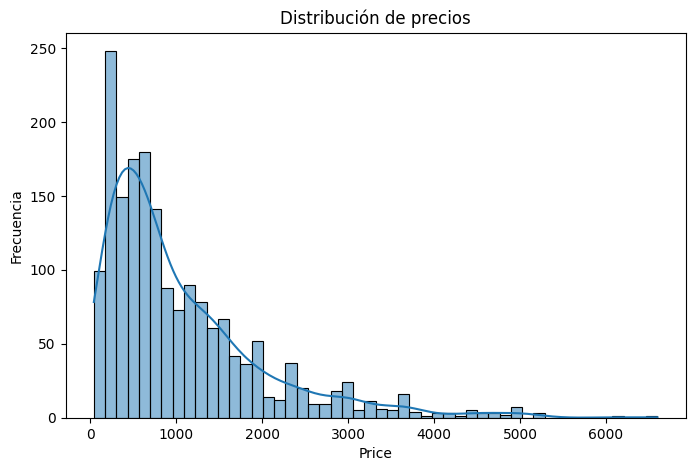

In [44]:
#distribución de los precios (vemos que la mayoría son más baratos que caros)

plt.figure(figsize=(8,5))
sns.histplot(lap["Price"], bins=50, kde=True)
plt.title("Distribución de precios")
plt.xlabel("Price")
plt.ylabel("Frecuencia")
plt.show()


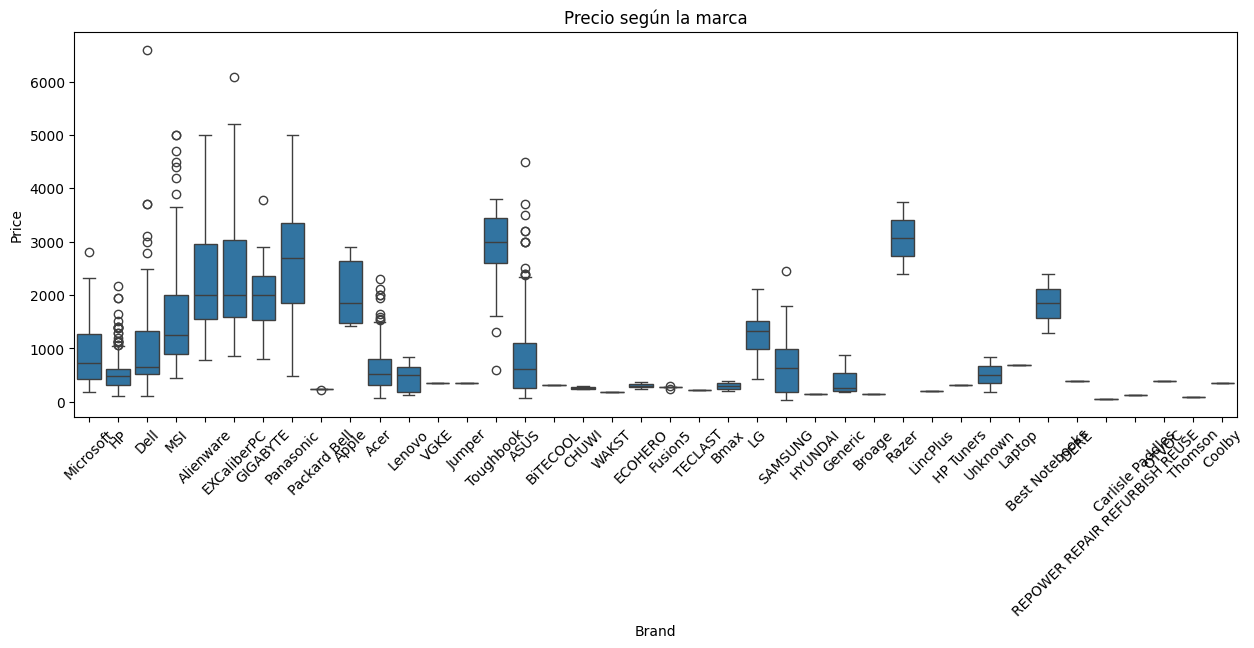

In [45]:
#boxplot para ver los precios según las marcas

plt.figure(figsize=(15,5))
sns.boxplot(x="Brand", y="Price", data=lap)
plt.xticks(rotation=45)
plt.title("Precio según la marca")
plt.show()


In [47]:
# Guardar dataset procesado si existe un DataFrame principal llamado 'lap'
from pathlib import Path
import pandas as pd
try:
    root = Path.cwd().parent  # asumiendo que ejecutas desde notebooks/
    out_dir = root / 'data' / 'processed'
    out_dir.mkdir(parents=True, exist_ok=True)
    if 'lap' in globals() and isinstance(lap, pd.DataFrame):
        lap.to_csv(out_dir / 'dataset_procesado.csv', index=False)
        print('[OK] Procesado guardado en data/processed/dataset_procesado.csv')
    else:
        print('[Aviso] No encuentro un DataFrame llamado lap; omito guardado automático.')
except Exception as e:
    print('[Aviso] No se pudo guardar el procesado:', e)


[OK] Procesado guardado en data/processed/dataset_procesado.csv
